# Import packages

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# Read dataframe from csv files

In [2]:
# Training data
df_train_spectroscope = pd.read_csv("train_spectroscope.csv")
df_train_CMOS = pd.read_csv("train_CMOS.csv")

# Testing data
df_test_spectroscope = pd.read_csv("test_spectroscope.csv")
df_test_CMOS = pd.read_csv("test_CMOS.csv")

# Extract the range of wavelengths
wavelength = np.array(df_train_spectroscope.columns[1:], dtype=float)

# Convert dataframe into arrays and normalize

In [3]:
# Scaling factors
S_Spectroscope = 5000
S_CMOS = 5000

# Spectroscope data
X = np.array(df_train_spectroscope.iloc[:, 1:]).astype(np.float32) / S_Spectroscope
X_tilde = np.array(df_test_spectroscope.iloc[:, 1:]).astype(np.float32) / S_Spectroscope

# CMOS data
Y = np.array(df_train_CMOS.iloc[:, 1:]).astype(np.float32) / S_CMOS
Y_tilde = np.array(df_test_CMOS.iloc[:, 1:]).astype(np.float32) / S_CMOS

# Define the reconstruction algorithm and plotting function

In [4]:
def reconstruct(X, Y, y_tilde, c1, c2, c3_1, c3_5, c3_9, c4_1):
    """
        Reconstruction algorithm: Use the CVXPY package to solve a convex optimization problem
        based on the input data and hyperparameters, and return the reconstructed spectroscope.

        Input:
            Data:
            X: Spectroscope of the training data
            Y: CMOS of the training data
            y_tilde: CMOS of the reconstructed spectroscope

            Hyperparameters:
            c1, c2, c3_1, c3_5, c3_9, c4_1: Regularization parameters

        Return:
            x_tilde: Reconstructed spectroscope
    """
    
    # Weights to solve for
    w = cp.Variable(Y.shape[0])
    
    # Forward differences
    dw_1 = w[1:] - w[:-1]
    dw_5 = w[5:] - w[:-5]
    dw_9 = w[9:] - w[:-9]

    # Build the optimization problem
    objective = cp.Minimize(
        cp.sum_squares(Y.T @ w - y_tilde)
        + c1 * cp.norm(w, 1)
        + c2 * cp.sum_squares(w)
        + c3_1 * cp.norm(dw_1, 1)
        + c3_5 * cp.norm(dw_5, 1)
        + c3_9 * cp.norm(dw_9, 1)
        + c4_1 * cp.sum_squares(dw_1)
    )
    constraints = [-1E-5 <= w]
    problem = cp.Problem(objective, constraints)

    # Solve the optimization problem and get the optimal objective value
    problem.solve(eps_prim_inf=1.0e-03, eps_dual_inf=1.0e-03, eps_abs=1.0e-03, eps_rel=1.0e-03)
    
    # Calculate the reconstructed spectroscope
    reconstruction = X.T @ w
    x_tilde = reconstruction.value
    
    return x_tilde


def plot_spectroscopes(true_spectroscope, reconstructed_spectroscope, wavelength, left_bound, right_bound):
    """
        Plotting function to visualize the true and predicted waves.
    """
    
    plt.figure()
    plt.plot(wavelength, true_spectroscope, label="True")
    plt.plot(wavelength, reconstructed_spectroscope, label="Reconstructed")
    plt.xlim(left_bound, right_bound)
    plt.legend()
    plt.title(f"COS Score = {np.corrcoef(true_spectroscope, reconstructed_spectroscope)[0,1]:.8f}")
    plt.show()

# Numerical Examples

In [5]:
# Set hyperparameters
c1 = 600
c2 = 0.1
c3_1 = 0.1
c3_5 = 0.02
c3_9 = 0.05
c4_1 = 0.06

### Single peak

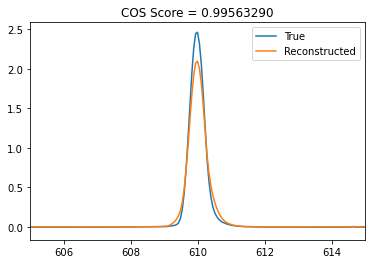

In [6]:
# ~610 nm

line = 2  # Line number of the testing data to be processed
left_bound = 605  # Left bound of the range for visualization
right_bound = 615  # Right bound of the range for visualization

reconstructed_spectroscope = reconstruct(X, Y, Y_tilde[line-2,:], c1, c2, c3_1, c3_5, c3_9, c4_1)
plot_spectroscopes(X_tilde[line-2,:], reconstructed_spectroscope, wavelength, left_bound, right_bound)

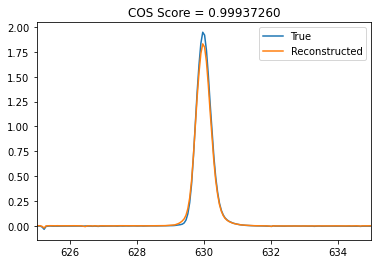

In [7]:
# ~630 nm

line = 3  # Line number of the testing data to be processed
left_bound = 625  # Left bound of the range for visualization
right_bound = 635  # Right bound of the range for visualization

reconstructed_spectroscope = reconstruct(X, Y, Y_tilde[line-2,:], c1, c2, c3_1, c3_5, c3_9, c4_1)
plot_spectroscopes(X_tilde[line-2,:], reconstructed_spectroscope, wavelength, left_bound, right_bound)

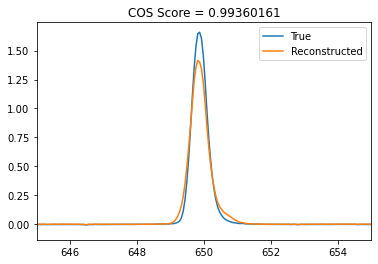

In [8]:
# ~650 nm

line = 4  # Line number of the testing data to be processed
left_bound = 645  # Left bound of the range for visualization
right_bound = 655  # Right bound of the range for visualization

reconstructed_spectroscope = reconstruct(X, Y, Y_tilde[line-2,:], c1, c2, c3_1, c3_5, c3_9, c4_1)
plot_spectroscopes(X_tilde[line-2,:], reconstructed_spectroscope, wavelength, left_bound, right_bound)

### Double peaks

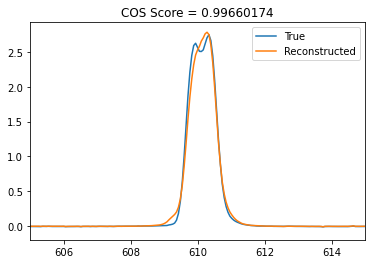

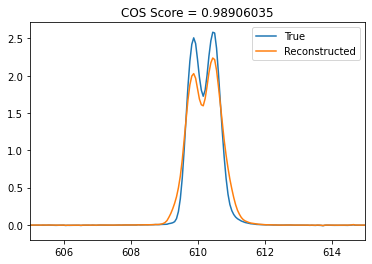

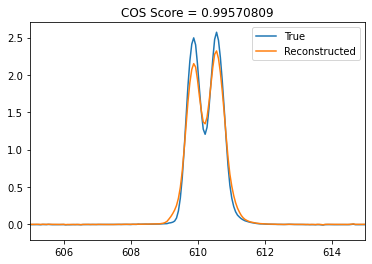

In [9]:
lines = [5, 6, 7]  # Line numbers of the testing data to be processed
left_bound = 605  # Left bound of the range for visualization
right_bound = 615  # Right bound of the range for visualization

for line in lines:
    reconstructed_spectroscope = reconstruct(X, Y, Y_tilde[line-2,:], c1, c2, c3_1, c3_5, c3_9, c4_1)
    plot_spectroscopes(X_tilde[line-2,:], reconstructed_spectroscope, wavelength, left_bound, right_bound)